In [1]:
import torch
from model import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_len": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_fe

In [2]:
import tiktoken
from generate_text import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model,
    text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_len'],
)

print(f"Output:\n{token_ids_to_text(token_ids, tokenizer)}")

Output:
Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Text Generation Loss
Need to do same steps as `generate_text_simple` to compute the loss

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                        [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [ "effort moves you",
                        [1107,  588, 11311]]) #   "really like chocolate"]

In [4]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f"Token IDs:\n{token_ids}")

Token IDs:
tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [6]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [7]:
# initial softmax probas corresponding to target tokens
# we want to maximize these, to be close to 1

text_idx = 0
# select "text_idx" batch
# select (i, targets[text_idx][i]) entry, the ith row and ith column
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
# each proba will be close to 1/50,257 initially
print(f"Text 1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f"Text 2: {target_probas_2}")

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Steps for Loss: <br>
Logits -> Probas -> Target Probas -> Log -> Average -> Negative

In [8]:
# steps 1-3 are done

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [9]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [10]:
neg_avg_log_probas = -1 * avg_log_probas
print(neg_avg_log_probas)

tensor(10.7940)


### Cross-Entropy Loss
The above steps calculated CE, which is implemented in PyTorch.

In [11]:
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [12]:
logits_flat = logits.flatten(0, 1)  # combine over the batch dimension
targets_flat = targets.flatten()

print(f"Flattened Logits: {logits_flat.shape}")
print(f"Flattened Targets: {targets_flat.shape}")

Flattened Logits: torch.Size([6, 50257])
Flattened Targets: torch.Size([6])


In [13]:
# PyTorch performs all the steps
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Perplexity
Measures how well the predicted proba distribution matches the actual distribution. <br>
Can be understood as the effective vocabulary size the model is uncertain about.

In [14]:
print(torch.exp(loss))  # model is uncertain about 48725 tokens

tensor(48725.8203)


## Training/Validation Set Losses

In [15]:
file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text_data = f.read()

In [16]:
total_chars = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Characters: {total_chars}")
print(f"Tokens: {total_tokens}")

Characters: 20479
Tokens: 5145


In [17]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [18]:
from dataloader import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_len=GPT_CONFIG_124M['context_len'],
    stride=GPT_CONFIG_124M['context_len'],
    drop_last=True,
    shuffle=True,
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_len=GPT_CONFIG_124M['context_len'],
    stride=GPT_CONFIG_124M['context_len'],
    drop_last=False,
    shuffle=False,
)

In [19]:
# verify

print("Train Loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nVal Loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Val Loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [20]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    
    return loss

In [21]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Training Loss: {train_loss}")
print(f"Val Loss: {val_loss}")

Training Loss: 10.987583584255642
Val Loss: 10.981106758117676


## Training

In [23]:
def train_model_simple(model,
                    train_loader, val_loader,
                    optimizer, device, num_epochs,
                    eval_freq, eval_iter,
                    start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
            
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}")
        
        generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
    model.train()
    
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()

    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, max_new_tokens=50, context_size=context_size)
    
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # compact print

    model.train()


In [24]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader,
    optimizer, device, num_epochs,
    eval_freq=5, eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)


Ep 1 (Step 000000): Train Loss 9.781, Val Loss 9.933
Ep 1 (Step 000005): Train Loss 8.111, Val Loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train Loss 6.661, Val Loss 7.048
Ep 2 (Step 000015): Train Loss 5.961, Val Loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train Loss 5.726, Val Loss 6.600
Ep 3 (Step 000025): Train Loss 5.201, Val Loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train Loss 4.417, Val Loss 6.278
Ep 4 (Step 000035): Train Loss 4.069, Val Loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train Loss 3.732, Val Loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    f, ax1 = plt.subplots(figsize=(5,3))

    ax1.plot(epochs_seen, train_losses, label='Training Loss')
    ax1.plot(epochs_seen, val_losses, label='Val Loss', linestyle='-.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only integer labels

    ax2 = ax1.twiny()  # share the same Y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # invisible plot to align ticks
    ax2.set_xlabel('Tokens Seen')

    f.tight_layout()
    plt.savefig('loss-plot.pdf')
    plt.show()

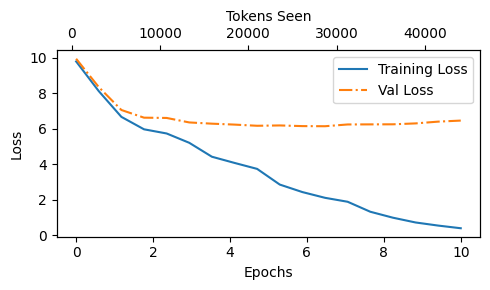

In [26]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding Strategies

In [27]:
model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')
# greedy decoding - selects token with highest proba, will generate same result each time
token_ids = generate_text_simple(model, text_to_token_ids("Every effort moves you", tokenizer), max_new_tokens=25, context_size=GPT_CONFIG_124M['context_len'])
print(f"Output:\n{token_ids_to_text(token_ids, tokenizer)}")

Output:
Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


### Temperature Scaling

In [28]:
#  probabilistic sampling, simple e.g

vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# assume LLM generates these
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

# map logits back to token IDs
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [29]:
torch.manual_seed(123)
# replace with probabilistic sampling
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])  # same result, cuz this had the highest proba and will get selected most of the time

forward


In [30]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)  # other tokens are also sampled

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


In [31]:
def softmax_with_temp(logits, temp):
    scaled = logits / temp
    return torch.softmax(scaled, dim=0)

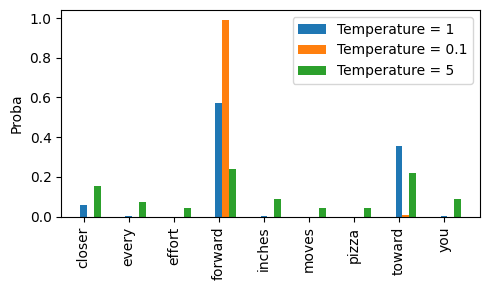

In [32]:
# less than 1 = higher confidence, sharper
# more than 1 = more uniform

temps = [1, 0.1, 5]
scaled_probas = [softmax_with_temp(next_token_logits, temp) for temp in temps]

x = torch.arange(len(vocab))
bar_width = 0.15

f, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temps):
    rects = ax.bar(x + i*bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Proba')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig('temp-plot.pdf')
plt.show()

### Ex 5.1
Sampling frequencies with temperature

In [33]:
for T in temps:
    print(f'Temperature: {T}')
    print_sampled_tokens(softmax_with_temp(next_token_logits, T))
    print()

Temperature: 1
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you

Temperature: 0.1
0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you

Temperature: 5
165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you



### Top-k Sampling

In [34]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(f"Top Logits: {top_logits}")
print(f"Top Positions: {top_pos}")

Top Logits: tensor([6.7500, 6.2800, 4.5100])
Top Positions: tensor([3, 7, 0])


In [36]:
new_logits = torch.where(condition=next_token_logits < top_logits[-1], input=torch.tensor(float('-inf')), other=next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [37]:
top_k_probas = torch.softmax(new_logits, dim=0)
print(top_k_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Updated Text Generation Function

In [38]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
        
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        # stop generating earlier than max_new_tokens on end-of-sequence
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [39]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_len'],
    top_k=25,
    temperature=1.4,
)

print(f"Output:\n{token_ids_to_text(token_ids, tokenizer)}")

Output:
Every effort moves you stand to work on surprise, a one of us had gone with random-


### Ex 5.2
Different temperatures and top-k settings.

In [43]:
from itertools import product
import random

temps = [0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 100.0]
top_k = [1, 5, 50, 100, 1000]

# make 5 random combinations
for T, K in random.choices(list(product(temps, top_k)), k=5):
    print(f"Settings: T={T}, K={K}")
    token_ids = generate(model, idx=text_to_token_ids("Every effort moves you", tokenizer),
            max_new_tokens=25, context_size=GPT_CONFIG_124M['context_len'],
            temperature=T,
            top_k=K)
    print(f"Output:\n{token_ids_to_text(token_ids, tokenizer).replace("\n", " ")}")
    print()

Settings: T=100.0, K=1000
Output:
Every effort moves youoring myself usual sketchagged Em standingusingrolledura desirehouse fell canvor tone adopted coatoud why bedr et central simple

Settings: T=1.0, K=1
Output:
Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun

Settings: T=0.5, K=1
Output:
Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun

Settings: T=2.0, K=5
Output:
Every effort moves you in the inevitable garlanded frame. The mere outline of the frame called up all Gisburn's an awful simpleton

Settings: T=3.0, K=1000
Output:
Every effort moves you drawn HerBe myself full ago thisling Donng do again"? genius across valuewing cheeks firstin mere did showbured



### Ex 5.3
Combination to force deterministic behavior

In [45]:
token_ids = generate(
    model, text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25, context_size=GPT_CONFIG_124M['context_len'],
    # no scaling, choose top-1
    # temperature=1.0, top_k=1,
    # or exploit the code structure to not take the if-condition paths
    temperature=0.0, top_k=None,
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


## Saving and Loading Weights

In [46]:
torch.save(model.state_dict(), "model.pth")

In [47]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_fe

In [48]:
# save optimizer too, useful to resume training
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "model_and_optimizer.pth")

In [49]:
# restore states

checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_fe